In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_excel(r'C:\Users\lenovo-002\PyCharmMiscProject\一定会成功的房屋预测\房屋数据_训练集.xlsx', sheet_name='房屋数据_训练集_独热编码')
test_data = pd.read_excel(r'C:\Users\lenovo-002\PyCharmMiscProject\一定会成功的房屋预测\房屋数据_测试集.xlsx', sheet_name='房屋数据_测试集_独热编码')

print("训练集形状:", train_data.shape)
print("测试集形状:", test_data.shape)
print("\n训练集前5行:")
print(train_data.head())
print("\n数据基本信息:")
print(train_data.info())

训练集形状: (270, 6)
测试集形状: (30, 6)

训练集前5行:
   房间数  建筑面积（单位：平米）  \
0  4.5       183.26   
1  4.0        87.27   
2  2.5        67.77   
3  2.5        72.40   
4  5.0       123.83   

  房屋朝向（东=[0,0,0,0,0,0,0,0,0];西=[0,1,0,0,0,0,0,0,0];南=[0,0,1,0,0,0,0,0,0];北=[0,0,0,1,0,0,0,0,0];东南=[0,0,0,0,1,0,0,0,0];东北=[0,0,0,0,0,1,0,0,0];西南=[0,0,0,0,0,0,1,0,0];西北=[0,0,0,0,0,0,0,1,0];南北=[0,0,0,0,0,0,0,0,1]）  \
0                                [0,0,0,0,0,0,1,0,0]                                                                                                                                                                 
1                                [0,0,1,0,0,0,0,0,0]                                                                                                                                                                 
2                                [0,0,1,0,0,0,0,0,0]                                                                                                                               

In [31]:
def create_features(df):
    orientation_features = pd.DataFrame(df['房屋朝向'].tolist(), 
                                     columns=[f'朝向_{i}' for i in range(9)])
    floor_features = pd.DataFrame(df['所在楼层'].tolist(), 
                                columns=[f'楼层_{i}' for i in range(3)])
    
    features = pd.concat([
        df[['房间数', '建筑面积（单位：平米）', '是否近地铁']].reset_index(drop=True),
        orientation_features,
        floor_features
    ], axis=1)
    
    return features

X_train = create_features(train_data)
y_train = train_data['房屋总价']
X_test = create_features(test_data)
y_test = test_data['房屋总价']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

print("标准化后的特征形状:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

标准化后的特征形状:
X_train_scaled: (270, 15)
X_test_scaled: (30, 15)


In [33]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [34]:
y_pred = ridge_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"初始模型性能:")
print(f"均方误差(MSE): {mse:.2f}")
print(f"R²分数: {r2:.4f}")

初始模型性能:
均方误差(MSE): 13795.10
R²分数: 0.8109


In [35]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

print(f"最佳参数: {grid_search.best_params_}")
print(f"最佳交叉验证分数: {grid_search.best_score_:.4f}")

最佳参数: {'alpha': 10}
最佳交叉验证分数: 0.6611


In [36]:
best_ridge = grid_search.best_estimator_
best_ridge.fit(X_train_scaled, y_train)

y_pred_best = best_ridge.predict(X_test_scaled)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"优化后模型性能:")
print(f"均方误差(MSE): {mse_best:.2f}")
print(f"R²分数: {r2_best:.4f}")

优化后模型性能:
均方误差(MSE): 12792.74
R²分数: 0.8247


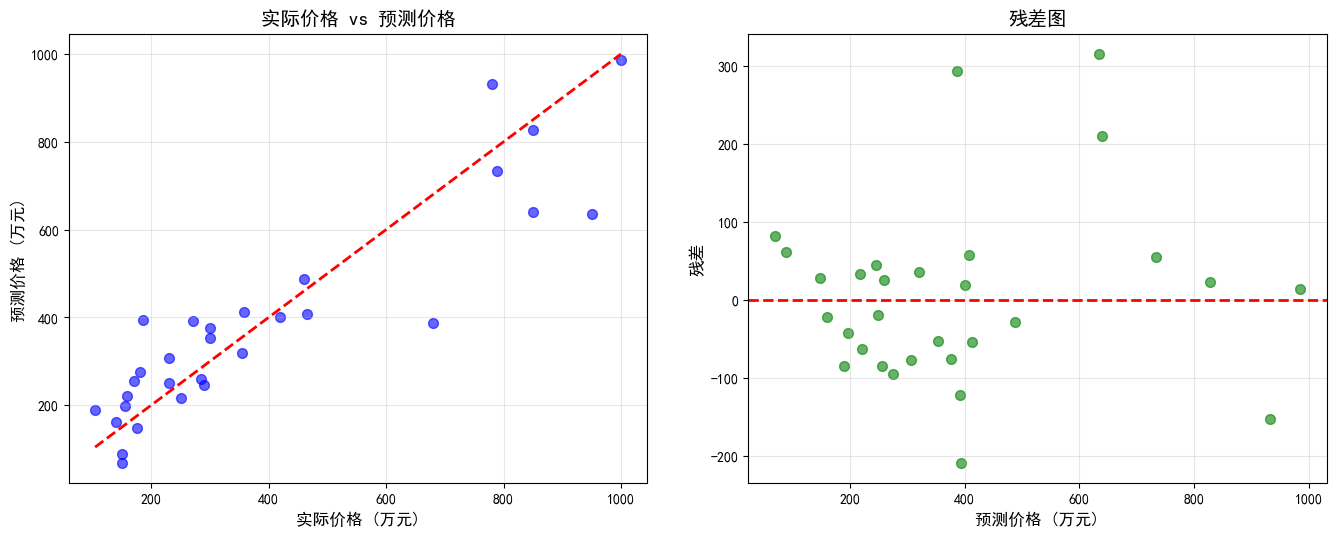

In [44]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  

# font_path = 'C:/Windows/Fonts/simhei.ttf'  
# font_path = 'C:/Windows/Fonts/msyh.ttc'  
# font_prop = font_manager.FontProperties(fname=font_path)

plt.figure(figsize=(14, 6)) 

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_best, alpha=0.6, color='blue', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('实际价格 (万元)', fontsize=12)
plt.ylabel('预测价格 (万元)', fontsize=12)
plt.title('实际价格 vs 预测价格', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.6, color='green', s=50)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('预测价格 (万元)', fontsize=12)
plt.ylabel('残差', fontsize=12)
plt.title('残差图', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout(pad=3.0)
plt.show()

In [43]:
improvement_mse = ((mse - mse_best) / mse) * 100
improvement_r2 = ((r2_best - r2) / r2) * 100
print(f"\n调参后性能提升:")
print(f"MSE 提升: {improvement_mse:.2f}%")
print(f"R² 提升: {improvement_r2:.2f}%")


调参后性能提升:
MSE 提升: 7.27%
R² 提升: 1.69%
